In [ ]:
from src.utils.compute_transition_matrix import compute_transition_matrix
from src.core.LangevinGillespie import LangevinGillespie
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

<hr>

### Initial Simulation Setup (Currently Supports 4 States)


In [ ]:
# Simulation Setup
LG = LangevinGillespie()
LG.steps = 2000
LG.dt = 1e-6
LG.method = "heun"

# Mechanical / Thermal Setup
LG.kappa = 56
LG.kBT = 4.14
LG.gammaB = LG.computeGammaB(a=20, r=19, eta=1e-9)

# Multi State Setup
LG.theta_states = np.array([3, 36, 72, 116]) * math.pi / 180  # Deg → Rad
LG.initial_state = 0  # Starting state

# Transition rate matrix
LG.transition_matrix = compute_transition_matrix(LG)

angles, states, thetas = LG.simulate()

In [ ]:
angles *= 180 / math.pi  # Convert to degrees
thetas *= 180 / math.pi  # Convert to degrees

<hr>

### Initial Simulation Results


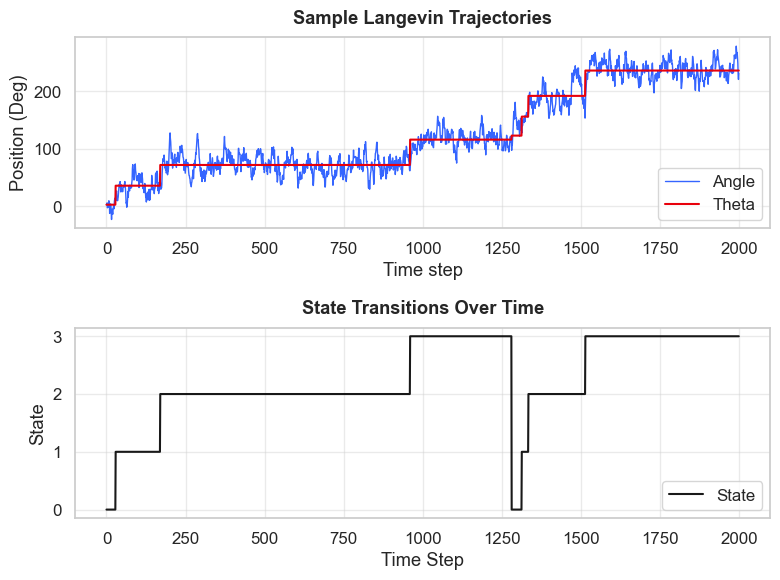

In [61]:
sns.set_theme(style="whitegrid", palette="bright", font_scale=1.1)
plt.figure(figsize=(8, 6))

# Top subplot
plt.subplot(2, 1, 1)
plt.plot(angles, color="b", alpha=0.8, linewidth=1, linestyle="-", label="Angle")
plt.plot(thetas, color="r", alpha=1, linewidth=1.5, linestyle="-", label="Theta")
plt.grid(True, alpha=0.4)
plt.xlabel("Time step")
plt.ylabel("Position (Deg)")
plt.title("Sample Langevin Trajectories", pad=10, weight="bold")
plt.legend(loc="lower right", frameon=True)

# Bottom subplot
plt.subplot(2, 1, 2)
plt.plot(states, color="black", alpha=0.9, linewidth=1.5, linestyle="-", label="State")
plt.ylabel("State")
plt.xlabel("Time Step")
plt.title("State Transitions Over Time", pad=10, weight="bold")
plt.grid(True, alpha=0.4)
plt.yticks(np.arange(len(LG.theta_states)))
plt.legend(loc="lower right", frameon=True)

plt.tight_layout()


<hr>

### Simulation PDF

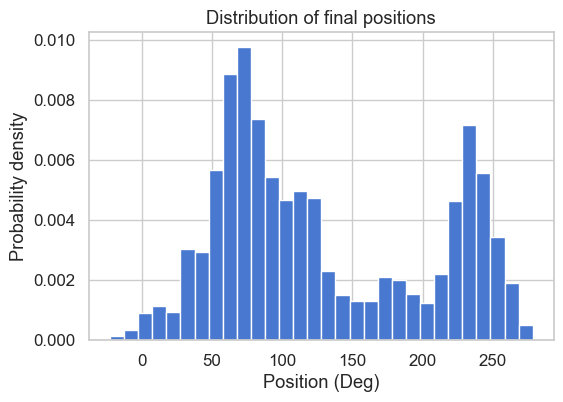

In [35]:
plt.figure(figsize=(6, 4))
plt.hist(angles, bins=30, density=True)
plt.xlabel("Position (Deg)")
plt.ylabel("Probability density")
plt.title("Distribution of final positions");

<hr>

### Four Simulations, each starting at a differing state


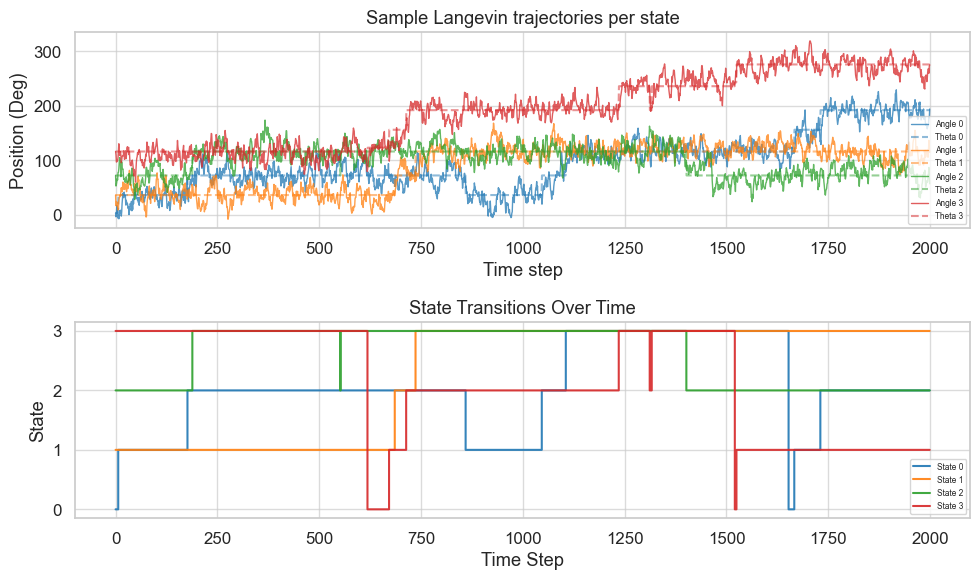

In [36]:
# Multi Simulation, starting at each state
all_angles = []
all_thetas = []
all_states = []

num_states = 4
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

# Simulate 4 times, each starting at a differing state from our theta_states array
for state in range(num_states):
    LG.initial_state = state
    angles_data, states_data, thetas_data = LG.simulate()
    angles_data *= 180 / math.pi  # Rad -> Deg
    thetas_data *= 180 / math.pi  # Rad -> Deg
    all_angles.append(angles_data)
    all_thetas.append(thetas_data)
    all_states.append(states_data)

all_angles = np.array(all_angles)
all_thetas = np.array(all_thetas)
all_states = np.array(all_states)

# Plot all simulations
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
for state in range(num_states):
    plt.plot(all_angles[state], color=colors[state], alpha=0.75, linewidth=1, label=f"Angle {state}")
    plt.plot(all_thetas[state], linestyle="--", color=colors[state], alpha=0.5, linewidth=1.5, label=f"Theta {state}")


plt.grid(True, alpha=0.7)
plt.xlabel("Time step")
plt.ylabel("Position (Deg)")
plt.title("Sample Langevin trajectories per state")
plt.legend(loc="lower right", fontsize=6)

plt.subplot(2, 1, 2)
for state in range(num_states):
    plt.step(range(len(all_states[state])), all_states[state], where="mid", color=colors[state], alpha=0.9, linewidth=1.5, label=f"State {state}")

plt.ylabel("State")
plt.xlabel("Time Step")
plt.title("State Transitions Over Time")
plt.grid(True, alpha=0.7)
plt.yticks(np.arange(len(LG.theta_states)))
plt.legend(loc="lower right", fontsize=6)

plt.tight_layout()